In [1]:
import tensorflow as tf

Basing the model on the "pix2pix" down- and upsampling model in the TensorFlow examples
https://www.tensorflow.org/tutorials/generative/pix2pix

In [2]:
# Downsample layer from pix2pix
def downsample(filter_channels, kernel_size, apply_batchnorm=True):
    """ Downsample layer from pix2pix
    
    # Input parameters:
    filter_channels:    Number of filters / "depth" of output
                        For images, this corresponds to number of color / wavelength channels
    kernel_size:        Spatial size of convolutional kernel
                        For images, if kernel_size = 3, each filter processes a 3x3 pixel neighborhood
    apply_batchnorm:    Boolean, whether to apply batch normalizetion (regularization)
                        before activation function.
    
    # Notes
    - Uses leaky ReLU activation
    - Slightly re-formatted by MHS
    """
    initializer = tf.random_normal_initializer(mean =0., stddev=0.02)              # Initializer for conv. layer                  

    result = tf.keras.Sequential()                                                 # Initialize as sequential (stack of layers),
    result.add(                                                                    # Add single conv. layer
        tf.keras.layers.Conv2D(filter_channels, kernel_size, 
                               strides=2, padding='same',                          # Strides and padding correspond to factor-2 downsample
                               kernel_initializer=initializer, use_bias=False))    # ??? Should we never use bias? Even when not using batch norm.?

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())                             # Optional: Add batch normalization layer

    result.add(tf.keras.layers.LeakyReLU())                                        # Activation function

    return result

In [3]:
# Upsample layer from pix2pix
def upsample(filter_channels, kernel_size, apply_dropout=False):
    """ Upsample layer from pix2pix
    
    # Input parameters:
    filter_channels:    Number of filters / "depth" of output
                        For images, this corresponds to number of color / wavelength channels
    kernel_size:        Spatial size of convolutional kernel
                        For images, if kernel_size = 3, each filter processes a 3x3 pixel neighborhood
    apply_dropout:      Boolean, whether to apply dropout (regularization)
                        before activation function.
                        
    # Notes
    - Always uses batch normalization
    - Uses "regular" ReLU activation
    - Slightly re-formatted by MHS
    """
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()                                                 # Initialize as stack of layers
    result.add(
        tf.keras.layers.Conv2DTranspose(filter_channels, kernel_size, 
                                        strides=2, padding='same',
                                        kernel_initializer=initializer,
                                        use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [8]:
def UNet(output_channels):
    # inputs = tf.keras.layers.Input(shape=[256, 256, 3])
    inputs = tf.keras.layers.Input(shape=[None, None, 3])   # Using None to signal variable image width and height
    kernel_size = 4
    
    down_stack = [
        downsample(64, kernel_size, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
        downsample(128, kernel_size),  # (batch_size, 64, 64, 128)
        downsample(256, kernel_size),  # (batch_size, 32, 32, 256)
        downsample(512, kernel_size),  # (batch_size, 16, 16, 512)
    ]

    up_stack = [
        upsample(256, kernel_size),  # (batch_size, 32, 32, 512)
        upsample(128, kernel_size),  # (batch_size, 64, 64, 256)
        upsample(64, kernel_size),   # (batch_size, 128, 128, 128)
    ]


    x = inputs

    # Downsampling through the model
    skips = []                    # List for saving references to downsampling layer outputs
    for down in down_stack:
        x = down(x)               # Run input x through layer, then set x equal to output
        skips.append(x)           # Add layer output to skips list

    skips = reversed(skips[:-1])  # Reverse list, and don't include skip for last layer ("bottom of U") 

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)                                     # Run input x through layer, then set x to output
        x = tf.keras.layers.Concatenate()([x, skip])  # Stack layer output together with skip connection (downsampling layer output with same resolution)
    
    # Define last layer, which upsamples to original resolution
    last = tf.keras.layers.Conv2DTranspose(output_channels, kernel_size,
                                     strides=2,
                                     padding='same',
                                     kernel_initializer = tf.random_normal_initializer(0., 0.02),
                                     activation='tanh')  # (batch_size, 256, 256, 3)    
    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [9]:
example_model = UNet(3)

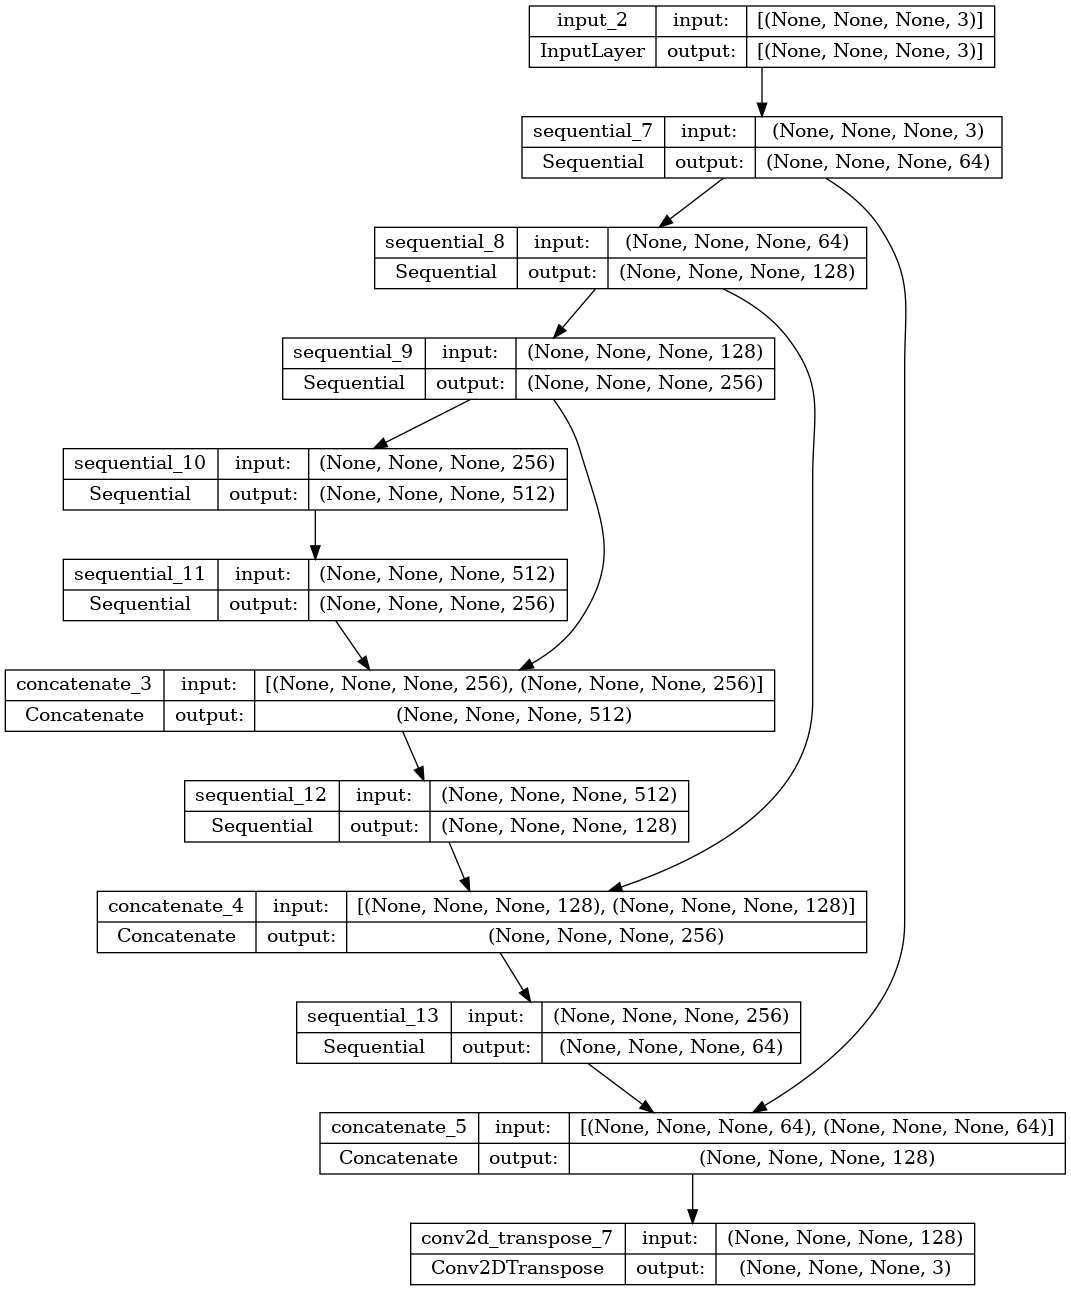

In [10]:
tf.keras.utils.plot_model(example_model, show_shapes=True)

In [21]:
# Try to create an arbitrarily shaped image
import numpy as np
noise_image = tf.expand_dims(np.random.normal(size=(512,512,3)),axis=0)

In [22]:
noise_image.shape

TensorShape([1, 512, 512, 3])

In [24]:
noise_output = example_model.predict(noise_image)

1/1 [==============================] - 0s 52ms/step


In [25]:
noise_output.shape

(1, 512, 512, 3)